In [3]:
from __future__ import annotations
from typing import Any, Optional
import uproot, hist
import numpy as np
from copy import deepcopy

In [4]:
fi = uproot.open("CI_2018_ElMu_HT.root")

In [5]:
%%timeit

x = [key for key in fi.keys(filter_name="*muRFcorrelated*")]

84.5 ms ± 690 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
%%timeit

x = [key for key in fi.keys() if "muRFcorrelated" in key]

55.4 ms ± 822 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
fi.keys()[0]

'ttH___HT500_nMediumDeepJetB0_nJet4___HT___nom;1'

In [8]:
len(fi.keys())

30650

In [9]:
len(fi.keys(filter_name="/.*___HT___.*mu(R|F).*/"))

9450

In [10]:
mus = fi.keys(filter_name="/.*___HT___.*mu(R|F).*/")

In [11]:
fi.keys(filter_name="/ttH___HT500_nMediumDeepJetB0_nJet4___HT___.*mu(R|F).*/")

['ttH___HT500_nMediumDeepJetB0_nJet4___HT___OSDL_RunII_ewkmuFNomRDown;1',
 'ttH___HT500_nMediumDeepJetB0_nJet4___HT___OSDL_RunII_ttmuFNomRDown;1',
 'ttH___HT500_nMediumDeepJetB0_nJet4___HT___OSDL_RunII_ttnobbmuFNomRDown;1',
 'ttH___HT500_nMediumDeepJetB0_nJet4___HT___OSDL_RunII_ttbbmuFNomRDown;1',
 'ttH___HT500_nMediumDeepJetB0_nJet4___HT___OSDL_RunII_ttultrararemuFNomRDown;1',
 'ttH___HT500_nMediumDeepJetB0_nJet4___HT___OSDL_RunII_ttVJetsmuFNomRDown;1',
 'ttH___HT500_nMediumDeepJetB0_nJet4___HT___OSDL_RunII_ttHmuFNomRDown;1',
 'ttH___HT500_nMediumDeepJetB0_nJet4___HT___OSDL_RunII_singletopmuFNomRDown;1',
 'ttH___HT500_nMediumDeepJetB0_nJet4___HT___OSDL_RunII_ttttmuFNomRDown;1',
 'ttH___HT500_nMediumDeepJetB0_nJet4___HT___OSDL_RunII_ewkmuFNomRUp;1',
 'ttH___HT500_nMediumDeepJetB0_nJet4___HT___OSDL_RunII_ttmuFNomRUp;1',
 'ttH___HT500_nMediumDeepJetB0_nJet4___HT___OSDL_RunII_ttnobbmuFNomRUp;1',
 'ttH___HT500_nMediumDeepJetB0_nJet4___HT___OSDL_RunII_ttbbmuFNomRUp;1',
 'ttH___HT500_nMedium

In [12]:
%%timeit

mus = fi.keys(filter_name="/.*___HT___.*mu(R|F).*/")
split_keys = [mu.split("___") for mu in mus]
procs = list(set([k[0] for k in split_keys]))
cats = list(set([k[1] for k in split_keys]))
variables = list(set([k[2] for k in split_keys]))
systs = list(set([k[3] for k in split_keys]))


71.9 ms ± 739 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
def make_QCDScales_with_rate_tttt(tfile, 
                                  mode="add", 
                                  filter_name="/tttt___.*___HT___OSDL_RunII_ttttmu.*/", 
                                  normalizations={
                                      "OSDL_RunII_ttttmuRFcorrelatedDown": 1.2991,
                                      "OSDL_RunII_ttttmuFNomRDown": 1.2298,
                                      "OSDL_RunII_ttttmuRNomFDown": 1.0753,
                                      "OSDL_RunII_ttttmuRNomFUp": 0.9358,
                                      "OSDL_RunII_ttttmuFNomRUp":  0.8088,
                                      "OSDL_RunII_ttttmuRFcorrelatedUp": 0.7490
                                  }
                                 ):
    _mode = mode.lower()
    if _mode not in ["add", "remove"]:
        raise ValueError(self.name + " requires mode to be 'add (scale)' or 'remove (divide out)' for the normalizations")
    
    
    ret = {}
    for k, v in tfile.items(filter_name=filter_name, cycle=False):
        mu_type = k.split("___")[-1]
        if _mode == "add":
            mu_factor = normalizations[mu_type]
            name = k.replace("ttttmu", "ttttmuWithRate")
        else:
            mu_factor = 1.0/normalizations[mu_type]
            name = k.replace("ttttmu", "ttttmuWithoutRate")
        ret[name] = mu_factor * v.to_hist()
    return ret
    

In [14]:
def make_envelope_hists(hist_list, nom_hist=None):
    """Wonky but minimally working 1D and 2D envelopes. Do not trust for more dimensions, it probably doesn't generalize."""
    new_axis=0 #don't play around with it
    new_hist_up = deepcopy(hist_list[0])
    new_hist_up.reset()
    new_hist_down = deepcopy(new_hist_up)
    
    values = []
    variances = []
    i = 0
    for i, h in enumerate(hist_list):
        values.append(h.values(flow=True))
        variances.append(h.variances(flow=True))
    if nom_hist:
        values.append(nom_hist.values(flow=True))
        variances.append(nom_hist.variances(flow=True))
    #Stack values and variances
    s_values = np.stack(values, axis=new_axis)
    s_variances = np.stack(variances, axis=new_axis)
    
    # Find the minima and maxima per bin, corresponding to new_axis
    s_val_argmax = np.argmax(s_values, axis=new_axis, keepdims=True)
    s_val_argmin = np.argmin(s_values, axis=new_axis, keepdims=True)
    
    # Get the corresponding minima and maxima and (for now) matching variances
    s_val_max = np.take_along_axis(s_values, s_val_argmax, axis=new_axis)[0]
    s_var_max = np.take_along_axis(s_variances, s_val_argmax, axis=new_axis)[0]
    s_val_min = np.take_along_axis(s_values, s_val_argmin, axis=new_axis)[0]
    s_var_min = np.take_along_axis(s_variances, s_val_argmin, axis=new_axis)[0]
    
    # Set the values and variances accordingly, this one doesn't use new_axis
    new_hist_up.view(flow=True)[...] = np.stack([s_val_max, s_var_max], axis=-1)
    new_hist_down.view(flow=True)[...] = np.stack([s_val_min, s_var_min], axis=-1)
    
    return new_hist_up, new_hist_down
    

In [15]:
def test_envelope():
    init = hist.Hist.new.Reg(3, 0, 3, name="x", flow=False).Reg(3, 0, 3, name="y", flow=False).Weight()
    a = deepcopy(init)
    b = deepcopy(init)
    c = deepcopy(init)
    a.values()[...] = np.array([[-2, -1, 0],
                                [-1, -1, 0],
                                [0, 1, 1]], dtype=np.int32).T[:, ::-1]
    b.values()[...] = np.array([[0, 1, 1],
                                [-2, 0, 1],
                                [-2, -1, -2]], dtype=np.int32).T[:, ::-1]
    c.values()[...] = np.array([[1, 0, -2],
                                [1, 1, -2],
                                [1, 0, 0]], dtype=np.int32).T[:, ::-1]
    d1, d2 = make_envelope_hists([a, b, c])
    #d2.plot()
    d2.plot()
    assert np.all(d1.values() == 1)
    print(d2.values()[:, :])
    assert np.all(d2.values()[0, :] == -2)
    assert np.all(d2.values()[1, :] == -1)
    assert np.all(d2.values()[2, :] == -2)

[[-2. -2. -2.]
 [-1. -1. -1.]
 [-2. -2. -2.]]


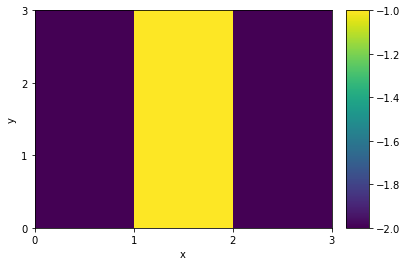

In [16]:
test_envelope()

In [17]:
def get_hist_storages(string: bool = True):
    available = [
        k for k in dir(hist.storage) if not (k in ["annotations"] or k.startswith("_"))
    ]
    if string:
        return available
    else:
        return tuple([getattr(hist.storage, a) for a in available])

def dict_to_hist_axis(
    histos: dict[str, hist.hist.Hist],
    axis_name: str,
    axis_label: str | None = None,
    axis_type: str = "StrCategory",
    axis_storage: str | None = None,
    axis_args: dict[str, Any] | None = None,
    axis_iter_override: Any | None = None,
) -> hist.hist.Hist:
    keys = []
    axes = None
    storage = None
    for it, (key, val) in enumerate(histos.items()):
        keys.append(key)
        if it == 0:
            axes = [axis for axis in val.axes]
            storage = val._storage_type()
    if axis_storage is None:
        pass  # use storage of the first histogram type
    elif isinstance(axis_storage, str):
        try:
            storage = getattr(hist.storage, axis_storage)()
        except:
            available_storages = get_hist_storages(string=True)
            raise ValueError(
                f"{axis_storage} not a valid type, choose from {available_storages}"
            )
    elif isinstance(axis_storage, get_hist_storages(string=False)):
        storage = axis_storage
    else:
        raise ValueError(f"Unsupport storage type requested: {axis_storage}")

    all_args = {
        "name": axis_name,
        "label": axis_label if axis_label else axis_name,
    }
    if axis_args:
        all_args.update(axis_args)

    flow = True
    # if "flow" in all_args:
    #     flow = all_args["flow"]

    # Determine iterable categories

    if axis_type == "Boolean":
        # Boolean(*, name: 'str' = '', label: 'str' = '', metadata: 'Any' = None, __dict__: 'dict[str, Any] | None' = None) -> 'None'
        new_axis = hist.axis.Boolean(**all_args)
        axes.insert(0, new_axis)
        h = hist.hist.Hist(
            *axes,
            storage,
        )
        for key, val in histos.items():
            if key.lower() == "true":
                idx = new_axis.index(True)
            elif key.lower() == "false":
                idx = new_axis.index(False)
            else:
                raise ValueError(f"Unsupported axis value for Boolean type: {key}")
            h.view(flow=flow)[idx, ...] = val.view(flow=flow)
    elif axis_type == "IntCategory":
        # IntCategory(categories: 'Iterable[int]', *, name: 'str' = '', label: 'str' = '', metadata: 'Any' = None, growth: 'bool' = False, __dict__: 'dict[str, Any] | None' = None) -> 'None'
        if axis_iter_override:
            iterator = axis_iter_override
        else:
            iterator = [int(key) for key in keys]
        new_axis = hist.axis.IntCategory(iterator, **all_args)
        axes.insert(0, new_axis)
        h = hist.hist.Hist(
            *axes,
            storage,
        )
        filled_keys = set()
        for key, val in histos.items():
            idx = new_axis.index(int(key))
            if idx in filled_keys:
                raise ValueError(
                    f"Duplicate key found for IntCategory type: {key} -> {int(key)}"
                )
            else:
                filled_keys.add(idx)
            h.view(flow=flow)[idx, ...] = val.view(flow=flow)
    elif axis_type == "Integer":
        # Integer(start: 'int', stop: 'int', *, name: 'str' = '', label: 'str' = '', metadata: 'Any' = None, flow: 'bool' = True, underflow: 'bool | None' = None, overflow: 'bool | None' = None, growth: 'bool' = False, circular: 'bool' = False, __dict__: 'dict[str, Any] | None' = None) -> 'None'
        if axis_iter_override:
            iterator = axis_iter_override
        else:
            iterator = [
                int(key) for key in keys if key.lower() not in ["underflow", "overflow"]
            ]
        if "start" not in all_args:
            all_args["start"] = min(iterator)
        if "stop" not in all_args:
            all_args["stop"] = max(iterator)
        new_axis = hist.axis.Integer(**all_args)
        axes.insert(0, new_axis)
        h = hist.hist.Hist(
            *axes,
            storage,
        )
        filled_keys = set()
        for key, val in histos.items():
            if key.lower() == "underflow":
                idx = new_axis.underflow
            elif key.lower() == "overflow":
                idx = new_axis.overflow
            else:
                idx = new_axis.index(int(key))
            if idx in filled_keys:
                raise ValueError(
                    f"Duplicate key found for Integer type: {key} -> {int(key)}"
                )
            else:
                filled_keys.add(idx)
            h.view(flow=flow)[idx, ...] = val.view(flow=flow)
    elif axis_type == "Regular":
        # Regular(bins: 'int', start: 'float', stop: 'float', *, name: 'str' = '', label: 'str' = '', metadata: 'Any' = None, flow: 'bool' = True, underflow: 'bool | None' = None, overflow: 'bool | None' = None, growth: 'bool' = False, circular: 'bool' = False, transform: 'bha.transform.AxisTransform | None' = None, __dict__: 'dict[str, Any] | None' = None) -> 'None'
        if axis_iter_override:
            iterator = axis_iter_override
        else:
            iterator = [
                float(key)
                for key in keys
                if key.lower() not in ["underflow", "overflow"]
            ]
        if "bins" not in all_args:
            all_args["bins"] = len(iterator)
        if "start" not in all_args:
            all_args["start"] = min(iterator)
        if "stop" not in all_args:
            all_args["stop"] = max(iterator)
        new_axis = hist.axis.Regular(**all_args)
        axes.insert(0, new_axis)
        h = hist.hist.Hist(
            *axes,
            storage,
        )
        filled_keys = set()
        for key, val in histos.items():
            if key.lower() == "underflow" and flow:
                idx = 0
            elif key.lower() == "overflow" and flow:
                idx = new_axis.extent - 1
            else:
                idx = new_axis.index(float(key))

            if idx in filled_keys:
                raise ValueError(
                    f"Duplicate key found for Integer type: {key} -> {float(key)}"
                )
            else:
                filled_keys.add(idx)
            h.view(flow=flow)[idx, ...] = val.view(flow=flow)
    elif axis_type == "StrCategory":
        # StrCategory(categories: 'Iterable[str]', *, name: 'str' = '', label: 'str' = '', metadata: 'Any' = None, growth: 'bool' = False, __dict__: 'dict[str, Any] | None' = None) -> 'None'
        if axis_iter_override:
            iterator = axis_iter_override
        else:
            iterator = [key for key in keys]
        new_axis = hist.axis.StrCategory(iterator, **all_args)
        axes.insert(0, new_axis)
        h = hist.hist.Hist(
            *axes,
            storage,
        )
        filled_keys = set()
        for key, val in histos.items():
            idx = new_axis.index(key)

            if idx in filled_keys:
                raise ValueError(
                    f"Duplicate key found for Variable type: {key} -> {float(key)}"
                )
            else:
                filled_keys.add(idx)
            h.view(flow=flow)[idx, ...] = val.view(flow=flow)
    elif axis_type == "Variable":
        # Variable(edges: 'Iterable[float]', *, name: 'str' = '', label: 'str' = '', metadata: 'Any' = None, flow: 'bool' = True, underflow: 'bool | None' = None, overflow: 'bool | None' = None, growth: 'bool' = False, circular: 'bool' = False, __dict__: 'dict[str, Any] | None' = None) -> 'None'
        if axis_iter_override:
            iterator = axis_iter_override
        else:
            iterator = sorted(
                [
                    float(key)
                    for key in keys
                    if key.lower() not in ["underflow", "overflow"]
                ]
            )
        new_axis = hist.axis.Variable(**all_args)
        axes.insert(0, new_axis)
        h = hist.hist.Hist(
            *axes,
            storage,
        )
        filled_keys = set()
        for key, val in histos.items():
            if key.lower() == "underflow" and flow:
                idx = 0
            elif key.lower() == "overflow" and flow:
                idx = new_axis.extent - 1
            else:
                idx = new_axis.index(float(key))

            if idx in filled_keys:
                raise ValueError(
                    f"Duplicate key found for Variable type: {key} -> {float(key)}"
                )
            else:
                filled_keys.add(idx)
            h.view(flow=flow)[idx, ...] = val.view(flow=flow)
    else:
        raise ValueError(f"Unsupported axis_type {axis_type}")

    return h


In [23]:
def make_QCDScales_envelopes(tfile,
                  top_filter_name="/.*___.*___HT___OSDL_RunII_.*mu(R|F).*(Down|Up)/"):
    keys = tfile.keys(filter_name=top_filter_name, cycle=False)
    skeys = [kk.split("___") for kk in keys]
    
    tttt_rates = make_QCDScales_with_rate_tttt(tfile, 
                                               mode="add", 
                                               filter_name=top_filter_name.replace(".*mu", "ttttmu")
                                               #filter_name=f"/tttt___.*___.*___OSDL_RunII_ttttmu.*/"
                                              )
                                             
    tree = {}
    ret_hists = {}
    ret_rates = {}
    for proc, cat, var, syst in skeys + [kk.split("___") for kk in tttt_rates]:
        if proc not in tree:
            tree[proc] = {}
        if cat not in tree[proc]:
            tree[proc][cat] = {}
        if var not in tree[proc][cat]:
            tree[proc][cat][var] = {}
        search_key = f"{proc}___{cat}___{var}___{syst}"
        if search_key in tttt_rates:
            tree[proc][cat][var][syst] = tttt_rates[search_key]
        else:
            tree[proc][cat][var][syst] = tfile[f"{proc}___{cat}___{var}___{syst}"].to_hist()
            
        #rates for the datacard maker
        if cat not in ret_rates:
            ret_rates[cat] = {}
        if proc not in ret_rates[cat]:
            ret_rates[cat][proc] = {}
    
    
    for proc in tree.keys():
        for cat in tree[proc].keys():
            for var in tree[proc][cat].keys():
                syst_hists = tree[proc][cat][var]
                nom_hist = tfile[f"{proc}___{cat}___{var}___nom"].to_hist()
                for env_set, disq in [(f"OSDL_RunII_{proc}muWithRate", "$NODISQ"),
                                      (f"OSDL_RunII_{proc}muWithoutRate", "$NODISQ"),
                                      (f"OSDL_RunII_{proc}mu", "Rate"),
                                     ]:
                    hist_name_base = f"{proc}___{cat}___{var}___{env_set}RFenvelope"
                    hist_list = [v for k,v in syst_hists.items() if k.startswith(env_set) and disq not in k]
                    #print(proc, cat, var, env_set, hist_list,"\n\n")
                    if len(hist_list) == 0:
                        continue
                    hist_env_up, hist_env_down = make_envelope_hists(hist_list, nom_hist=nom_hist)
                    #alt_base = dict_to_hist_axis({k:v for k,v in syst_hists.items() if k.startswith(env_set) and disq not in k},
                    #                             "systematic",
                    #                             "systematic",
                    #                             "StrCategory",
                    #                             hist.storage.Weight(),
                    #                             {"growth": True},
                    #                             None
                    #                             )
                    #if proc == "tttt" and cat == "HT500_nMediumDeepJetB4p_nJet8p":
                    #    print("\n".join([axis.name for axis in alt_base.axes]))
                    #    alt_base_up = alt_base[{"systematic": hist.tag.Slicer()[::sum]}]
                    #    print(alt_base_up.values())
                    #    print(hist_env_up.values())
                        
                    ret_hists[hist_name_base + "Up"] = hist_env_up
                    ret_hists[hist_name_base + "Down"] = hist_env_down
                    ret_rates[cat][proc][hist_name_base + "Up"] = hist_env_up.sum().value
                    ret_rates[cat][proc][hist_name_base + "Down"] = hist_env_down.sum().value
                    
                    #print(proc, cat, var, env_set, len(hist_list))
    return ret_hists, ret_rates
        

In [21]:
tx, ty = make_QCDScales_envelopes(fi,
             "/tt.*___HT500_nMediumDeepJetB4p_nJet.*___HT___OSDL_RunII_.*mu(R|F).*(Down|Up)/")

ttH HT500_nMediumDeepJetB4p_nJet4 HT OSDL_RunII_ttHmu 6
ttH HT500_nMediumDeepJetB4p_nJet5 HT OSDL_RunII_ttHmu 6
ttH HT500_nMediumDeepJetB4p_nJet6 HT OSDL_RunII_ttHmu 6
ttH HT500_nMediumDeepJetB4p_nJet7 HT OSDL_RunII_ttHmu 6
ttH HT500_nMediumDeepJetB4p_nJet8p HT OSDL_RunII_ttHmu 6
tttt HT500_nMediumDeepJetB4p_nJet4 HT OSDL_RunII_ttttmuWithRate 6
tttt HT500_nMediumDeepJetB4p_nJet4 HT OSDL_RunII_ttttmu 6
tttt HT500_nMediumDeepJetB4p_nJet5 HT OSDL_RunII_ttttmuWithRate 6
tttt HT500_nMediumDeepJetB4p_nJet5 HT OSDL_RunII_ttttmu 6
tttt HT500_nMediumDeepJetB4p_nJet6 HT OSDL_RunII_ttttmuWithRate 6
tttt HT500_nMediumDeepJetB4p_nJet6 HT OSDL_RunII_ttttmu 6
tttt HT500_nMediumDeepJetB4p_nJet7 HT OSDL_RunII_ttttmuWithRate 6
tttt HT500_nMediumDeepJetB4p_nJet7 HT OSDL_RunII_ttttmu 6
systematic
xaxis
[0.152393   0.22195465 0.26191446 0.34044223 0.34296751 0.36496076
 0.47366361 0.42105138 0.49064017 0.44361057 0.50165621 0.45619936
 0.45287376 0.45281817 0.42899735 0.33470727 0.37769843 0.25494066
 0.22

In [25]:
#uproot.pyroot.to_pyroot(tx['ttH___HT500_nMediumDeepJetB4p_nJet4___HT___OSDL_RunII_ttHmuRFenvelopeUp'])


Welcome to JupyROOT 6.26/04


AttributeError: 'Hist' object has no attribute '_serialize'

In [20]:
x = fi["ttH___HT500_nMediumDeepJetB0_nJet4___HT___nom"].to_hist()#.axes[0].traits.overflow

In [47]:
xx = deepcopy(x)
xx.values(flow=True)[:] = np.zeros_like(len(x.values(flow=True)))

In [58]:
xx.view(flow=True)[...] = np.stack([np.zeros_like(x.values(flow=True)), 
                                    np.zeros_like(x.values(flow=True))], axis=-1)


In [60]:
xx.variances()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [35]:
x.values(flow=True)

array([0.00000000e+00, 1.66912358e-02, 1.30024031e-02, 8.99397599e-03,
       8.07180463e-03, 8.13546605e-03, 6.57024435e-03, 1.04886333e-02,
       2.93144193e-03, 3.82167367e-03, 1.93109735e-03, 3.22293712e-03,
       1.48469085e-03, 2.30199715e-03, 5.95403490e-04, 1.05042909e-03,
       0.00000000e+00, 1.79968240e-03, 2.06838065e-04, 2.07632863e-05,
       2.42304950e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.51644444e-04, 3.29641693e-04, 0.00000000e+00, 2.55682276e-04])

In [45]:
y = hist.Hist.new.Reg(10, 0, 10, name="y", flow=False).Double()
y.fill([0, 1, 2, 3, 4, 3, 4, 2, 5, 6])
y.values(flow=True)

array([1., 1., 2., 2., 2., 1., 1., 0., 0., 0.])

In [50]:
yy = deepcopy(y)
yy.reset()
yy

Hist(Regular(10, 0, 10, underflow=False, overflow=False, name='y', label='y'), storage=Double())

In [47]:
di

['__add__',
 '__annotations__',
 '__array__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__idiv__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__isub__',
 '__itruediv__',
 '__le__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__setitem__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '_axis',
 '_compute_commonindex',
 '_compute_inplace_op',
 '_compute_uhi_index',
 '_export_bh_',
 '_family',
 '_from_histogram_object',
 '_generate_axes_',
 '_hist',
 '_import_bh_',
 '_index_transform',
 '_loc_shortcut',
 '_name_to_index',
 '_new_hist',
 '_reduce',
 '_repr_html_',
 '_step_shortcut',
 '_storage_type',
 '_type